## Focal statistics over a time series

In this example, we want to illustrate how to calculate focal statistic and determine hot and cold spots of NDVI (Normalized difference vegetation index) over a time series, from 2016 to 2020. These information helps us to have an overview of the change in terms of plant cover over the years. While the NDVI represents if the target being observed contains live green vegetation, its hot and cold spots help determining the recovery or disappearance of plants. In this notebook, we'll see how to:

- search for satellite data by item IDs using `pystac_client`
- visualize true color images
- calculate NDVI
- smooth images with a mean filter
- define a kernel representing neighborhood of a feature, i.e a pixel in an image.
- calculate focal statistics of the values within a specified focal neighborhood for each pixel in an input data array.
- identify statistically significant hot spots and cold spots in an input data array.

The focus of this notebook is to analyse information for each pixel based on its focal neighborhood kernel. The Focal Module from `xarray-spatial`, [xrspatial.focal](https://xarray-spatial.org/user_guide/focal.html) provides a set of analysis tools performing neighborhood operations that will be used through this tutorial. Input for these focal tools can be a Numpy-backed, or Dask with Numpy-backed xarray DataArray. For some functions, CuPy-backed DataArray is also supported. And the output of a function will have the same type as of input. So if we pass in a Dask DataArray, the return will also be a Dask DataArray.

The input data used in this example are sentinel-2 satellite images.

### Imports

In [1]:
import planetary_computer as pc

import numpy as np
import xarray as xr

import stackstac
import pystac_client

import matplotlib.pyplot as plt

import xrspatial.multispectral as ms
from xrspatial.convolution import calc_cellsize, circle_kernel, convolution_2d
from xrspatial.focal import mean, focal_stats, hotspots

from dask.distributed import Client, LocalCluster

### Local Dask Cluster

In [2]:
cluster = LocalCluster()
client = Client(cluster)

cluster.scale(4)
print(cluster.dashboard_link)

/srv/conda/envs/notebook/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45291 instead
  warnings.warn(


http://127.0.0.1:45291/status


### Data

The region of interest is a small region in Amazon rainforest, located in State of Mato Grosso and State of Amazonas, Brazil. In order to calculate NDVI accurately, we found these least cloudy scenes by searching with the [STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and filtering the results.

In [3]:
catalog = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')

ids = [
    'S2A_MSIL2A_20160627T142042_N0212_R010_T20LQR_20210211T234456.SAFE',
    'S2B_MSIL2A_20170727T142039_N0212_R010_T20LQR_20210210T153028.SAFE',
    'S2B_MSIL2A_20180712T142039_N0212_R010_T20LQR_20201011T150557.SAFE',
    'S2B_MSIL2A_20190617T142049_N0212_R010_T20LQR_20201006T032921.SAFE',
    'S2A_MSIL2A_20200616T141741_N0212_R010_T20LQR_20200822T232052.SAFE',
]

search = catalog.search(
    collections=['sentinel-2-l2a'],
    ids=ids
)

for item in search.items():
    print(f"{item.id} has a cloud cover of {item.properties['eo:cloud_cover']}")

S2B_MSIL2A_20190617T142049_N0212_R010_T20LQR_20201006T032921.SAFE has a cloud cover of 0.001523
S2A_MSIL2A_20200616T141741_N0212_R010_T20LQR_20200822T232052.SAFE has a cloud cover of 0.001108
S2B_MSIL2A_20180712T142039_N0212_R010_T20LQR_20201011T150557.SAFE has a cloud cover of 0.001831
S2A_MSIL2A_20160627T142042_N0212_R010_T20LQR_20210211T234456.SAFE has a cloud cover of 0.00218
S2B_MSIL2A_20170727T142039_N0212_R010_T20LQR_20210210T153028.SAFE has a cloud cover of 0.002621


In [4]:
items = [pc.sign_assets(i).to_dict() for i in search.items()]

Consider 4 bands: blue, green, red and nir08

In [5]:
data = (
    stackstac.stack(
        items,
        epsg=32619,
        resolution=100,
        assets=['B02', 'B03', 'B04', 'B08'],  # blue, green, red, nir
        chunksize=2048, # set chunk size to 2048 to get one chunk per time step
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band = lambda x: x.common_name.rename("band"))  # use common names
)
data

<xarray.DataArray 'stackstac-1ed32dfeafad98c658b11d2d1bec1379' (time: 5, band: 4, y: 1127, x: 1109)>
dask.array<where, shape=(5, 4, 1127, 1109), dtype=float64, chunksize=(1, 1, 1127, 1109), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2016-06-27...
    id                                       (time) <U65 'S2A_MSIL2A_20160627...
  * band                                     (band) <U5 'blue' 'green' ... 'nir'
  * x                                        (x) float64 1.362e+06 ... 1.472e+06
  * y                                        (y) float64 -9.079e+05 ... -1.02...
    s2:product_uri                           (time) <U65 'S2A_MSIL2A_20160627...
    ...                                       ...
    title                                    (band) <U14 'Band 2 - Blue' ... ...
    proj:shape                               object {10980}
    common_name                              (band) <U5 'blue' 'green' ... 'nir'
    center_wavelength                        (band) float64 0.49 0.56 ... 0.842
    full_width_half_max                      (band) float64 0.098 ... 0.145
    epsg                                     int64 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(1361700, -1020600, 1472600, -...
    crs:         epsg:32619
    transform:   | 100.00, 0.00, 1361700.00|\n| 0.00,-100.00,-907900.00|\n| 0...
    resolution:  100

In [6]:
data = data.compute()

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


### True color

Let's see how the data actually looks by visualizing them with `true_color` function from [xrspatial.multispectral](https://xarray-spatial.org/reference/multispectral.html)

To hide the label for x and y axes from sub-plots, we can update `rcParams` for `matplotlib.pyplot` as below:

In [7]:
rc = {
    "axes.spines.left" : False,
    "axes.spines.right" : False,
    "axes.spines.bottom" : False,
    "axes.spines.top" : False,
    "xtick.bottom" : False,
    "xtick.labelbottom" : False,
    "ytick.labelleft" : False,
    "ytick.left" : False
}

plt.rcParams.update(rc)

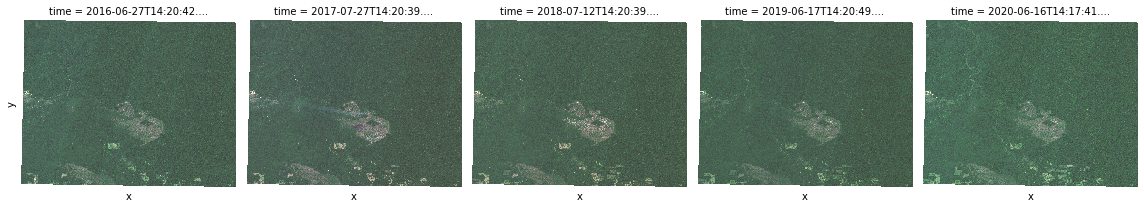

In [8]:
true_color_aggs = [
    ms.true_color(
        x.sel(band='red'),
        x.sel(band='green'),
        x.sel(band='blue')
    ) for x in data
]

true_color = xr.concat(true_color_aggs, dim="time")
true_color.coords['time'] = data.coords['time']

# visualize
t = true_color.plot.imshow(x='x', y='y', col='time', col_wrap=5, cmap='viridis')

### [NDVI](https://xarray-spatial.org/reference/_autosummary/xrspatial.multispectral.ndvi.html)

NDVI for annual data can be calculated with `xarray-spatial`

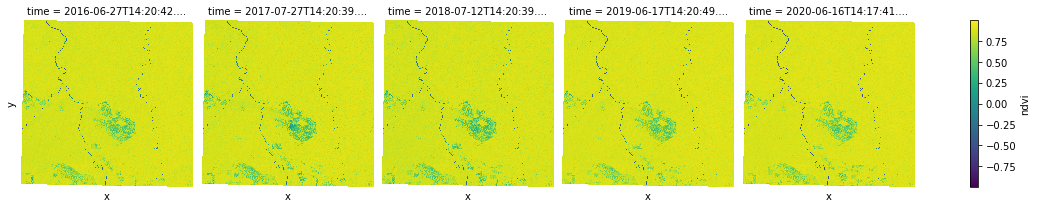

In [9]:
ndvi_aggs = [
    ms.ndvi(
        x.sel(band='nir'), x.sel(band='red')
    ) for x in data
]

ndvi = xr.concat(ndvi_aggs, dim="time")

ndvi.plot.imshow(x='x', y='y', col='time', col_wrap=5, cmap='viridis')

### Smoothing Images with [Focal Mean](https://xarray-spatial.org/reference/_autosummary/xrspatial.focal.mean.html)

`focal.mean` can be used to smooth or reduce noises in an image by applying a 3x3 window kernel. 

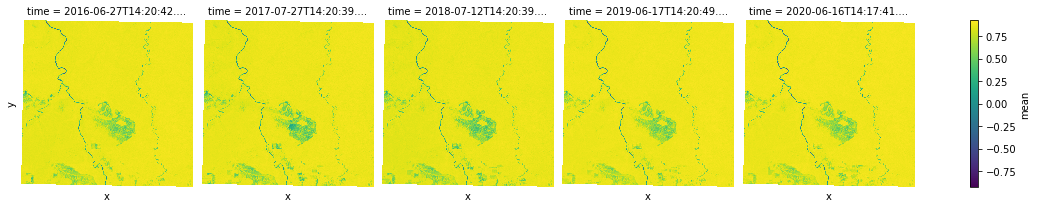

In [10]:
mean_aggs = [
    mean(ndvi_agg) for ndvi_agg in ndvi_aggs
]

smooth = xr.concat(mean_aggs, dim="time")

s = smooth.plot.imshow(x='x', y='y', col='time', col_wrap=5, cmap='viridis')

### [Focal statistics](https://xarray-spatial.org/user_guide/focal.html#)

In this step, we calculate focal statistics using a circular kernel for the NDVI data arrays computed above. 7 types of statistics will be computed by default, which are: Mean, Max, Min, Range, Std, Var, and Sum. Results of this function will be a 3D data array with the newly added dimension of `stats` (abbr for statistics). To perform the computation:
- We first need to find out the cellsize of input data array to get the scaling right.
- Then create a circular kernel with expected radius. 
- And, finally, we can compute focal statistics for each point in the terrain with `xrspatial.focal.focal_stats`.

In this example, each pixel represents a region of `100m x 100m`, let's consider a circular kernel with a radius of 1.5km, equivalent to 15 times of the input cellsize.

In [11]:
cellsize = calc_cellsize(ndvi)
cellsize

(100.0, 100.0)

In [12]:
kernel = circle_kernel(*cellsize, radius=15*cellsize[0])
kernel.shape

(31, 31)

In [13]:
%%time
stats_aggs = [
    focal_stats(ndvi_agg, kernel) for ndvi_agg in ndvi_aggs
]

stats = xr.concat(stats_aggs, dim="time")

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


CPU times: user 4min 53s, sys: 1.35 s, total: 4min 54s
Wall time: 4min 41s


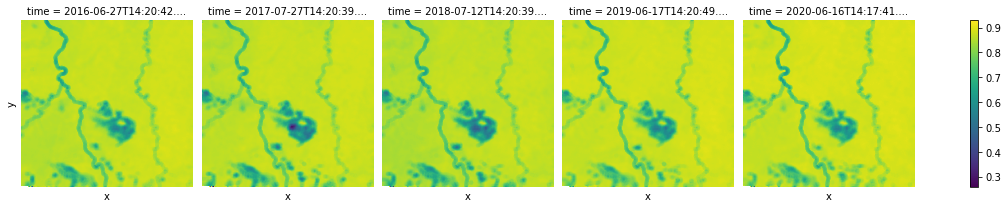

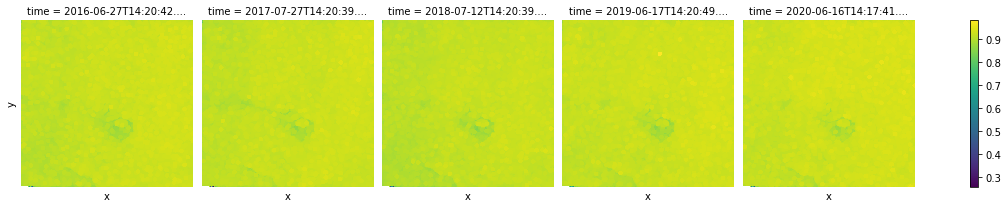

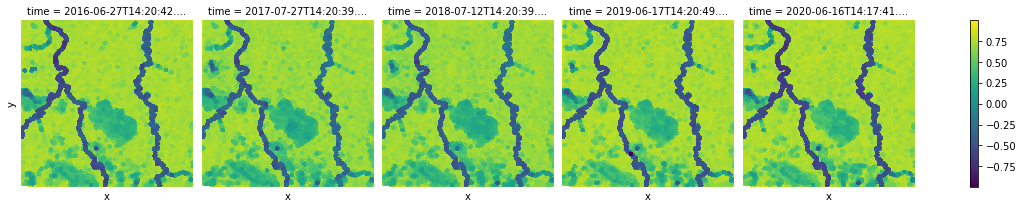

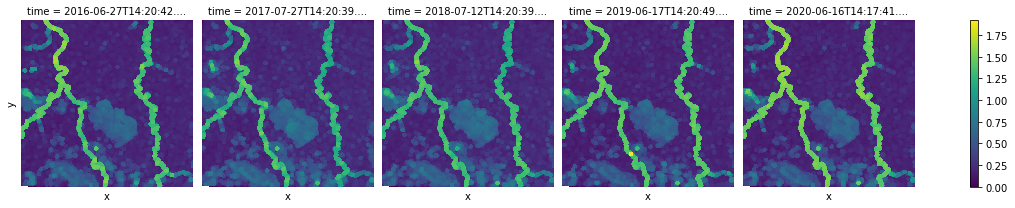

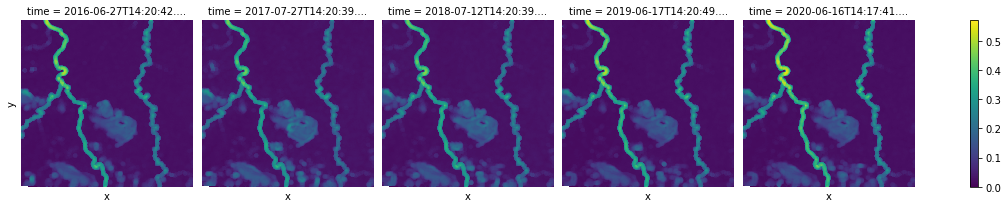

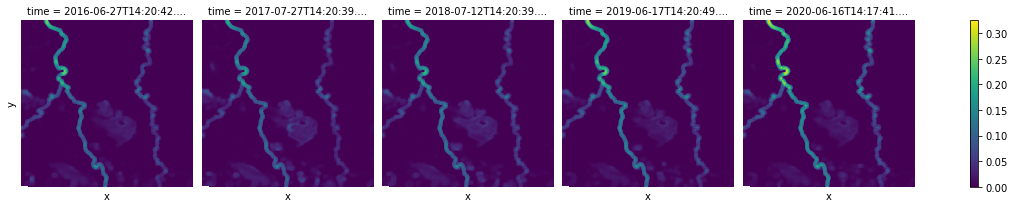

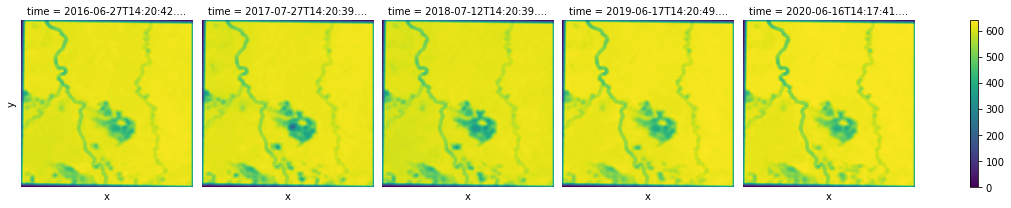

In [14]:
# transpose the data array so `stats` dimension appears first
stats_t = stats.transpose('stats', 'time', 'y', 'x')

for stats_img in stats_t:
    g = stats_img.plot.imshow(x='x', y='y', col='time', col_wrap=5, cmap='viridis')

Since the input for `focal_stats` is a Dask-backed xarray DataArray, the output is also Dask-backed. To visuallize efficiently, let's compute the results.

### Custom statistics

Sometimes you may want to a different statistic than the options provided in `focal_stats`, or you want to apply a custom kernel to your images. That's when you can think about using `convolution.convolution_2d` to calculate, for all inner cells of an array, the 2D convolution of each cell. Convolution is frequently used for image processing, such as smoothing, sharpening, and edge detection of images by eliminating spurious data or enhancing features in the data.

Let's experiment a horizontal Sobel kernel.

In [15]:
# Use Sobel operator
sobel_kernel = np.array(
    [[1, 0, -1],
     [2, 0, -2],
     [1, 0, -1]]
)

sobel_kernel

array([[ 1,  0, -1],
       [ 2,  0, -2],
       [ 1,  0, -1]])

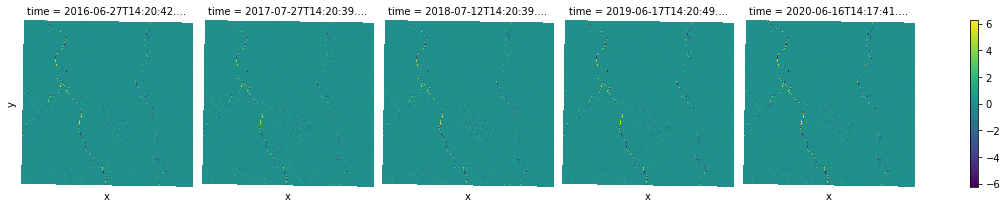

In [16]:
sobel_aggs = [
    convolution_2d(ndvi_agg, sobel_kernel) for ndvi_agg in ndvi_aggs
]

sobel_agg = xr.concat(sobel_aggs, dim="time")

sobel_agg.plot.imshow(x='x', y='y', col='time', col_wrap=5, cmap='viridis')

### [Hotspots](https://xarray-spatial.org/reference/_autosummary/xrspatial.focal.hotspots.html?highlight=hotspots#xrspatial.focal.hotspots)
 
Similar to other focal tools, to identify hot and cold spots in a data aggregate, we need to provide a kernel, which is a numpy ndarray, along with the input data array to be analysed. There are 7 possible values for a pixel of the results of `hotspots` function

- +90 for 90% confidence high value cluster (hot spot)
- +95 for 95% confidence high value cluster
- +99 for 99% confidence high value cluster
- -90 for 90% confidence low value cluster (cold spot)
- -95 for 95% confidence low value cluster
- -99 for 99% confidence low value cluster
- 0 for no significance

A statistically significant hot spot will be recognized when it has a high value and be surrounded by other features with high values as well. In constrast, a cold spot has a low value and be surrounded by other low values features.

Using the 1.5km circular kernel defined above, let's identify hot and cold spots for the computed NDVI data arrays.

Hotspots are identified using z-scores of all cells in a input raster, which requires a global mean to be defined. Currently, `focal.hotspots` does not perform well in term of finding nan-mean of a Dask-backed data array, so let's use pure numpy-backed version for this.

In [17]:
%%time
hotspots_aggs = [
    hotspots(ndvi_agg, kernel) for ndvi_agg in ndvi
]

hotspots_ndvi = xr.concat(hotspots_aggs, dim="time")

CPU times: user 29.3 s, sys: 144 ms, total: 29.5 s
Wall time: 8.69 s


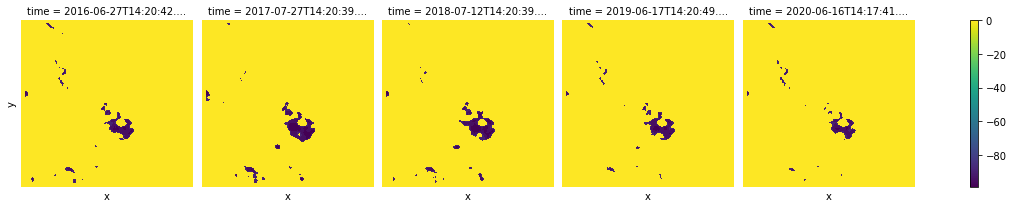

In [18]:
hotspots_ndvi.plot.imshow(x='x', y='y', col='time', col_wrap=5, cmap='viridis')

In [19]:
np.unique(hotspots_ndvi)

array([-99, -95, -90,   0], dtype=int8)

Looking into the results above, we can see that there only cold spots detected for this region. They expanded mostly from 2017 to 2018 and has been gradually recovered in 2020.

### Next steps
To find out more about xarray-spatial focal statistics and other toolsets provided by the library, please visit: https://xarray-spatial.org/index.html